# Ice Station Zebra Pipeline Demo

This demonstration showcases the complete Ice Station Zebra ML pipeline capabilities through CLI commands. 

**Target Audience:** Developer teams and future team members who want to understand our design decisions, 
trade-offs, and flexible experimentation capabilities.

**You'll learn how to:**
- Run our training pipeline end-to-end in three lines of code
- Swap between different modelling paradigms
- Reproduce runs and inspect the outputs
- Evaluate the performance of the models in line with community standards on sea ice forecasting

## Demo Structure

**Section 1: End-to-End Training**
- Run a full zebra pipeline end-to-end using a minimal configuration & data
- Inspect training artifacts and see evaluation outputs

**Section 2: Model Flexibility**
- Switch between Encode-Process-Decode paradigm and standalone persistence model
- Explore Encoder module functionality (Multimodality)

**Section 3: Evaluation Framework**
- Evaluate and compare model performance using a pretrained model checkpoint
- Explore different plotting formats and metrics

**Section 4: Train it yourself - Advanced Example**
- use anemoi functionality to fetch and inspect standard datsets
- write your own config to train a model on a full dataset
- see our pipeline data checks and validation in action

# Section 1: End-to-End Training Pipeline

In this section, we'll demonstrate the complete training pipeline using a simple **UNet model with a naive encoder / decoder** (more details of this can be found below in section 2). 
The dataset contains sea ice concentration data (OSISAF) and corresponding atmospheric data (ERA5).
We don't expect the model to do well, but it will give us a sense of the pipeline.

**N.B. to run this minimal example requires you to have signed up to access the ERA5 data. Details on how to do so can be found below.**

You can install the repo by running the following commands in your terminal:

```bash
git clone https://github.com/alan-turing-institute/ice-station-zebra
cd ice-station-zebra
pip install .
```

### Environment Verification

Let's verify that our zebra cli tools are available and working.

To run this notebook, you'll need a kernel (e.g. conda or .venv) with the ice_station_zebra repo and jupyter installed.

In [3]:
!zebra --help

/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field u

### Download the dataset for running the model

This assumes you have a folder called `my_data/` in the root of the repo.

In [4]:
!zebra datasets create --config-name=demo_nb.yaml

/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field u

### Train the model

In [5]:
!zebra train --config-name=demo_nb.yaml

/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field u

### Evaluate the model

In [6]:
!zebra evaluate --config-name=demo_nb.yaml --checkpoint="../my_data/training/naive_unet_naive_demo_south/wandb/latest-run/checkpoints/epoch=9-step=1810.ckpt"

/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field u

We can then check the predictions from this model. (N.b. as it is only run for a small number of epochs on a limited dataset, the results are not great.)

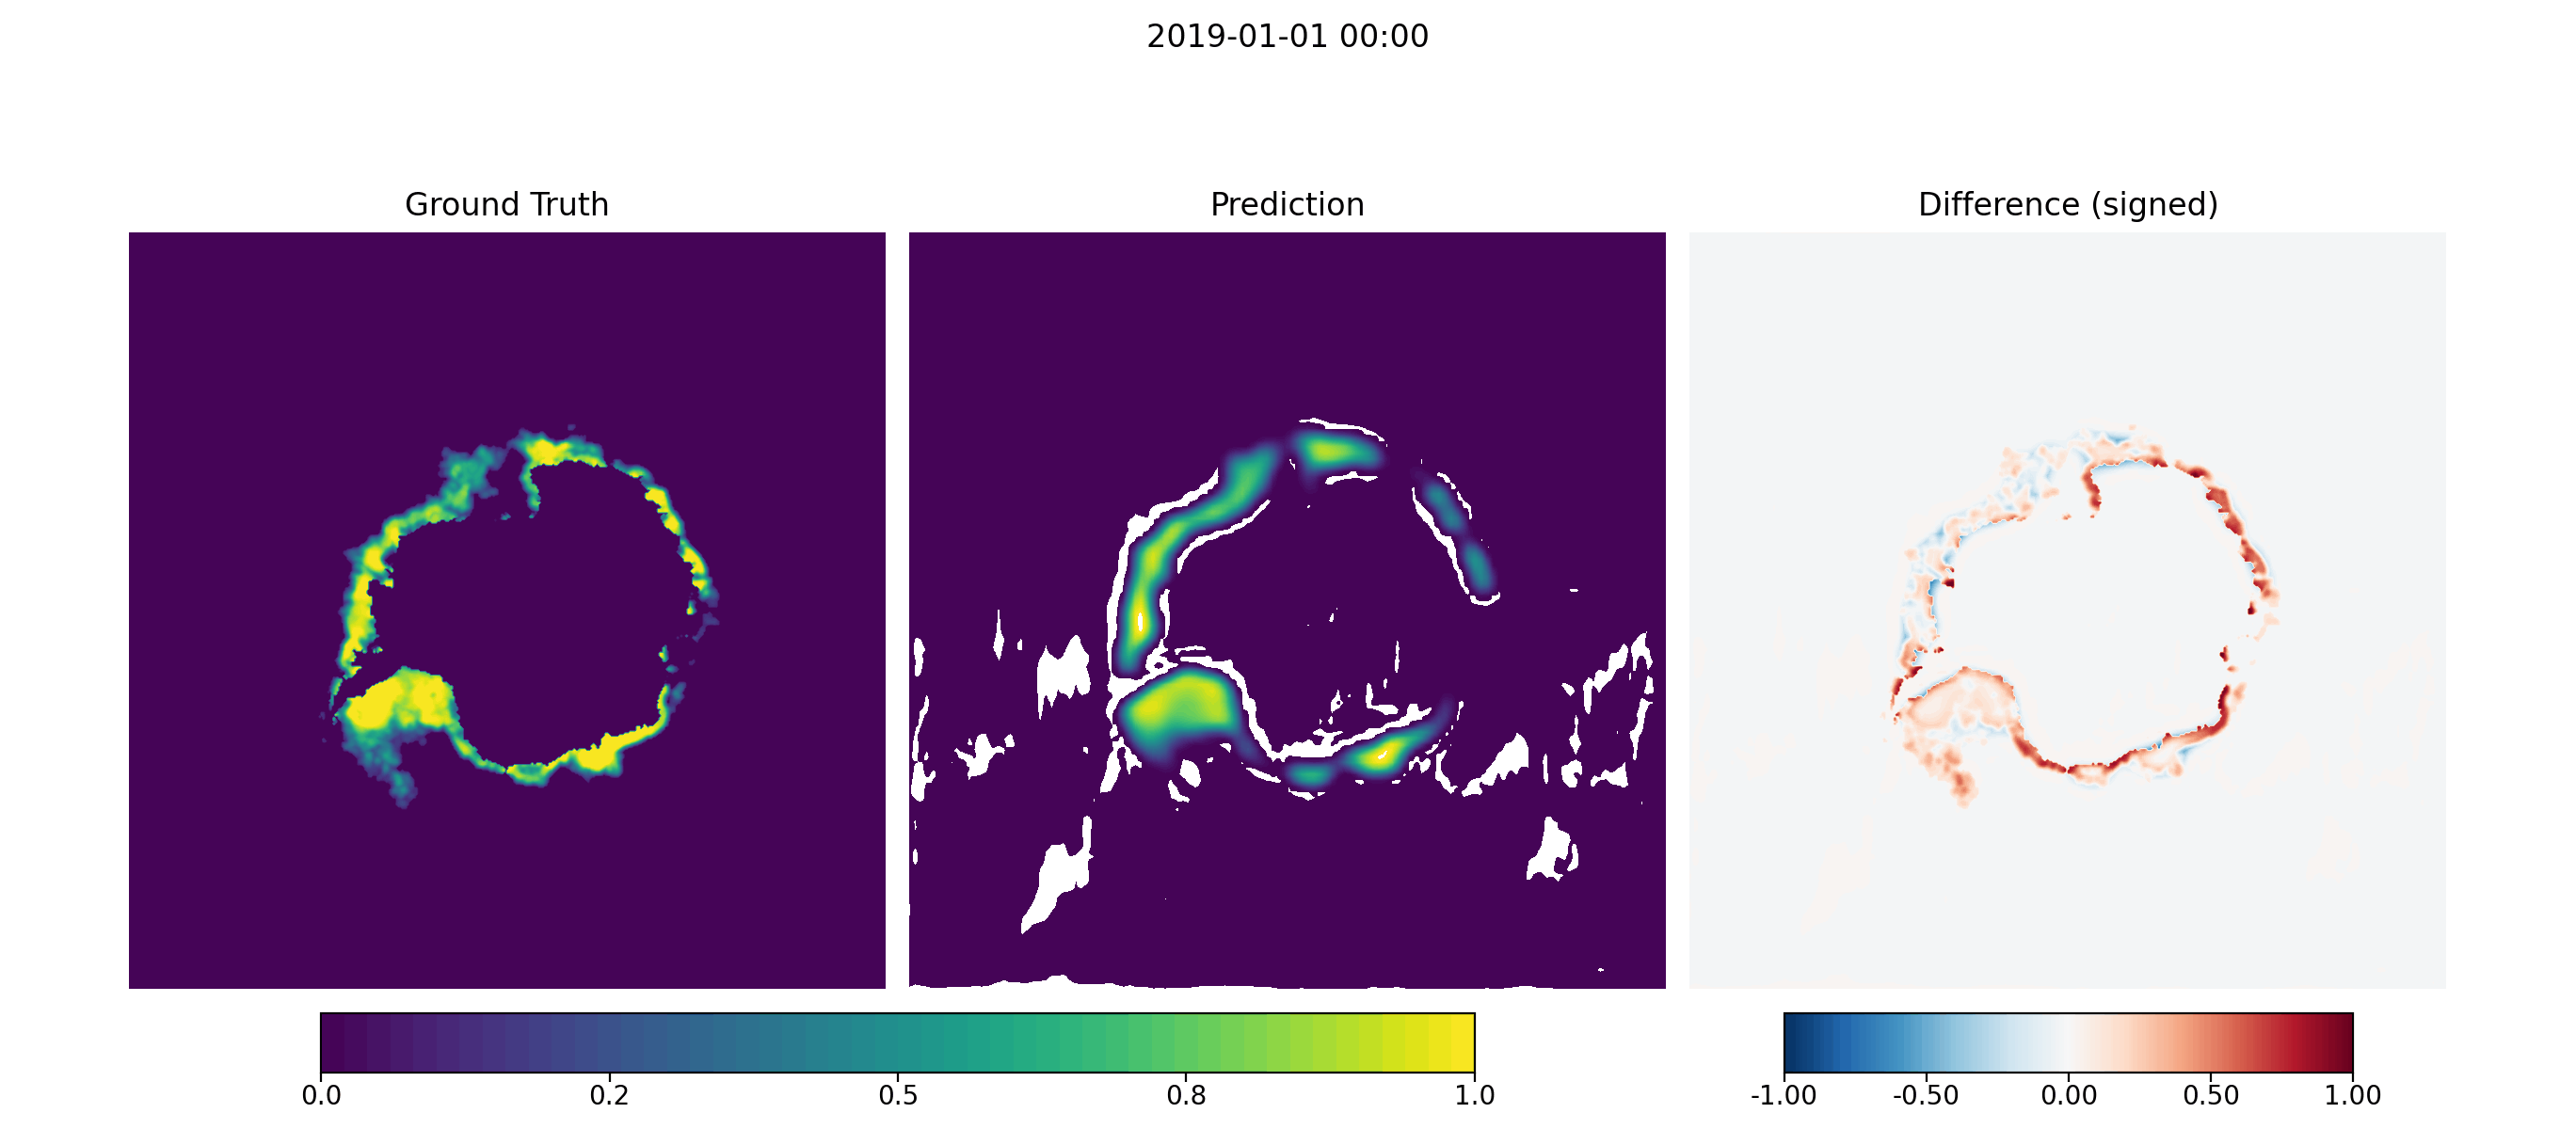

In [17]:
import os
from IPython.display import Image

# extract the file name (it has a random variable on the end)
folder = "../my_data/training/naive_unet_naive_demo_south/wandb/latest-run/files/media/videos/"
file = os.path.join(folder, os.listdir(folder)[0])

Image(filename=file)

# Section 2: Model Flexibility

In this section, we'll demonstrate how easy it is to switch between different model architectures.
We'll show the difference between standalone models and processor models.

The conceptually simpler model type is a standalone model, which takes in the input data and directly outputs the prediction. These models are less flexible, as they have to be specifically coded to handle new input / output data. Consequently a separate instance of the model is likely to be needed for each input / output combination. However, the input variables are available without transformation.  

![pipeline_standalone](../docs/assets/pipeline-standalone.png)

The more complex model type is processor model, which uses an encode-process-decode paradigm. Here, the input data is first encoded into a latent representation, which is then processed by a core model, before being decoded back into the output space. This allows for more flexibility in terms of input and output variables, as well as the ability to use different types of models for each component.

![pipeline_encode_process_decode](../docs/assets/pipeline-encode-process-decode.png)

## Using an alternative processor model

Here we replace the naive_unet_naive model, which is the default with a naive_vit_naive model.

In [19]:
!zebra train --config-name=demo_nb.yaml model=naive_vit_naive loggers.wandb.name=naive_vit_naive_demo_south

/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field u

In [22]:
!zebra evaluate --config-name=demo_nb.yaml --checkpoint="../my_data/training/naive_vit_naive_demo_south/wandb/latest-run/checkpoints/epoch=9-step=1810.ckpt"  loggers.wandb.name=naive_vit_naive_demo_south

/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field u

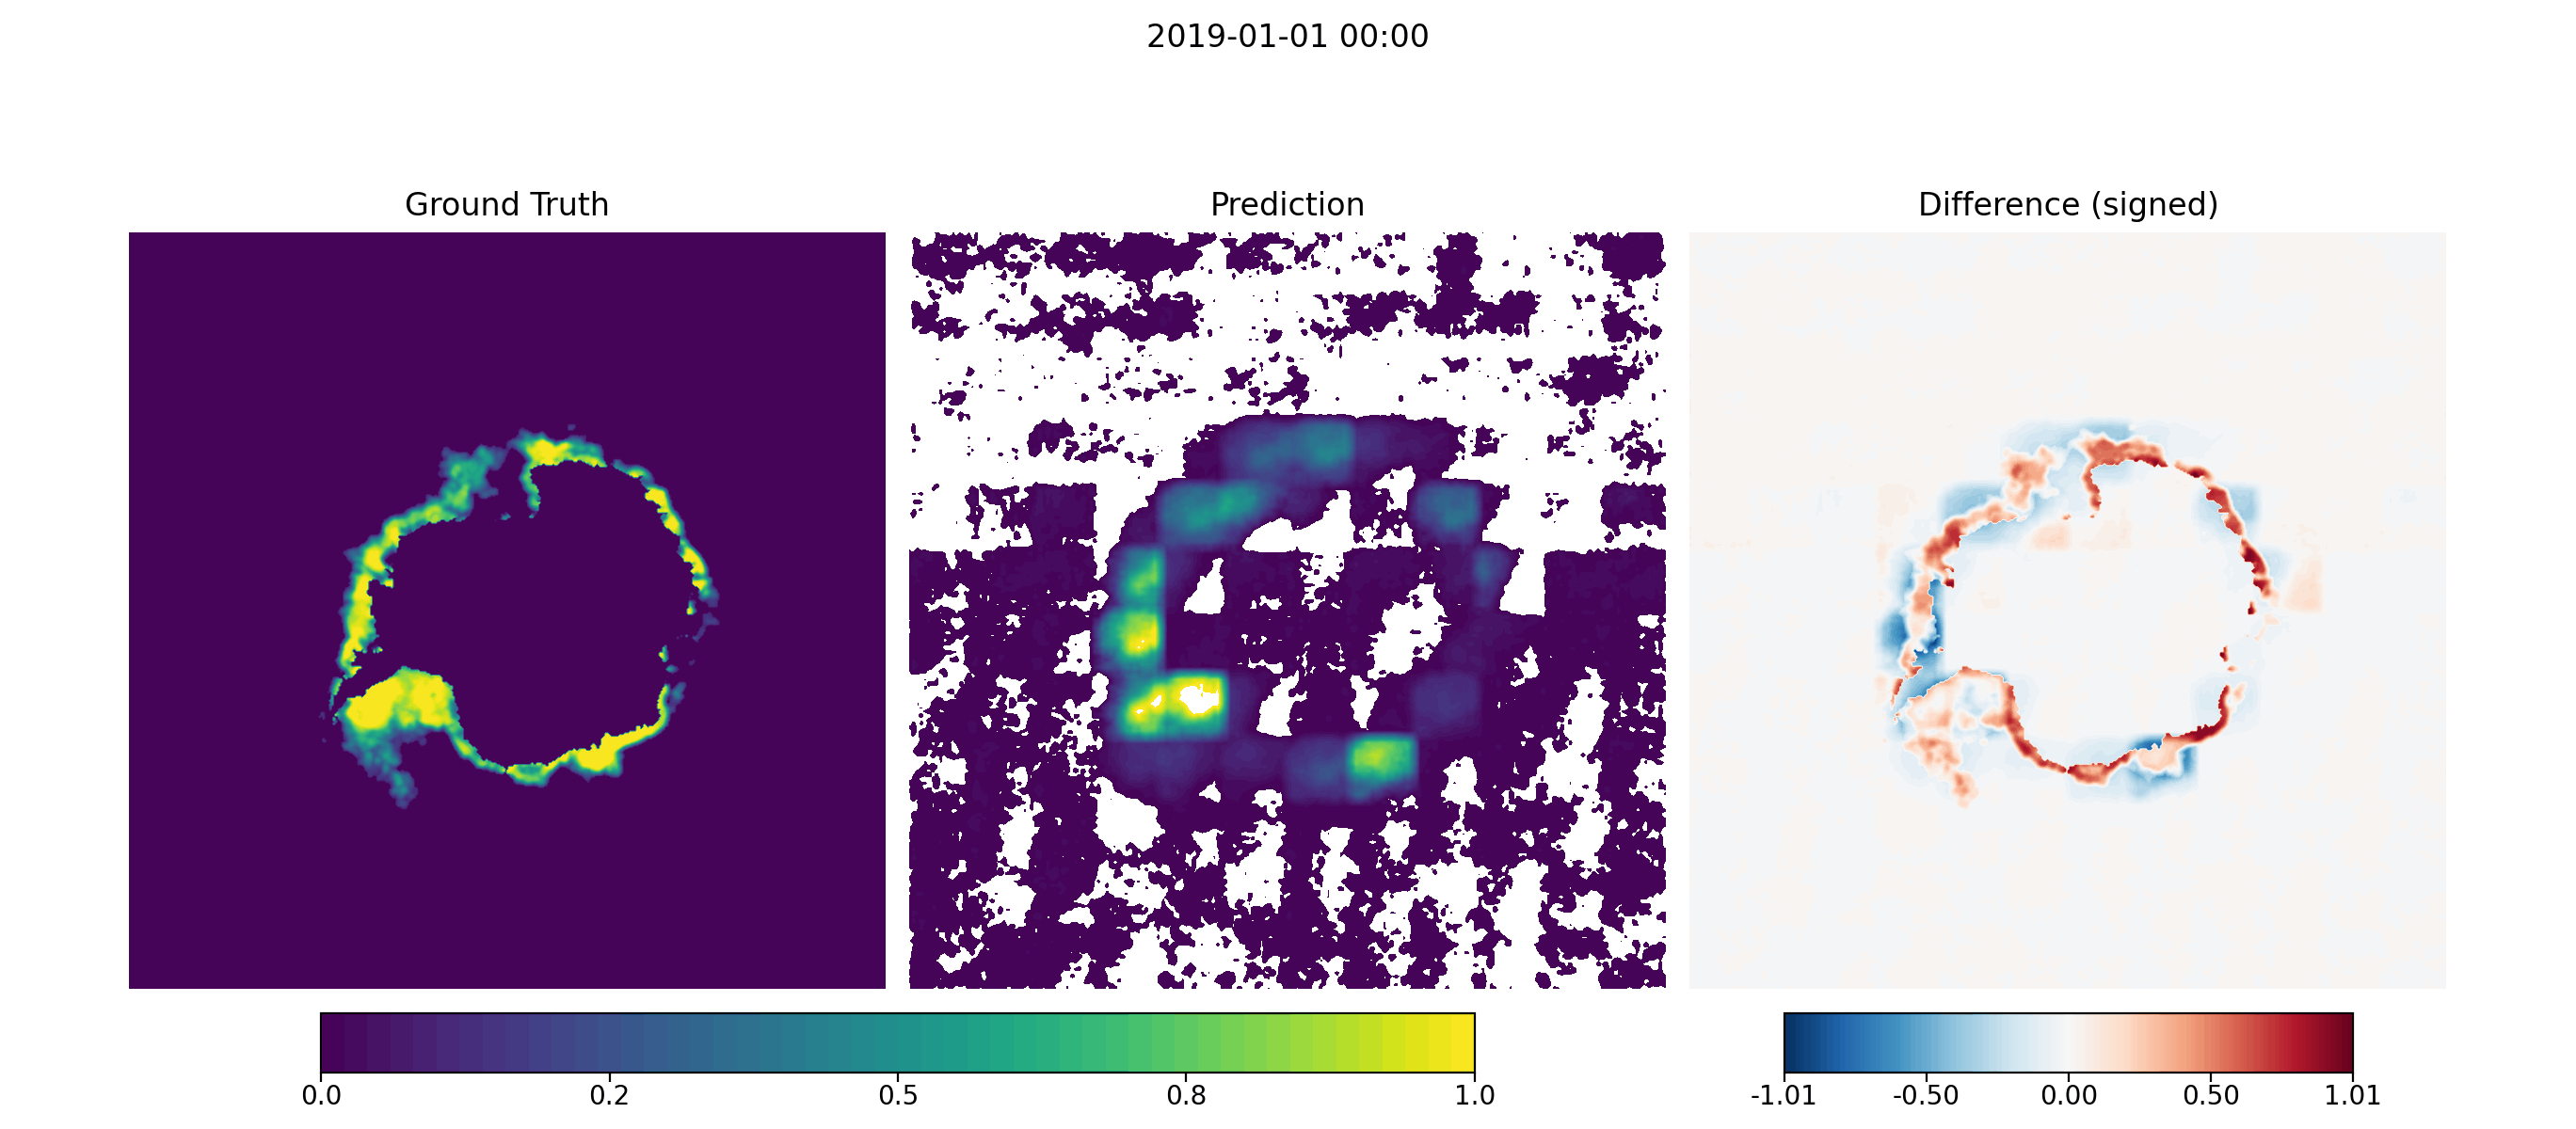

In [23]:
# extract the file name (it has a random variable on the end)
folder = "../my_data/training/naive_vit_naive_demo_south/wandb/latest-run/files/media/videos/"
file = os.path.join(folder, os.listdir(folder)[0])

Image(filename=file)

## Standalone persistence model

An alternative form of model doesn't use an encoder / decoder architecture. In this case we use a persistence model which simply outputs the last input frame as the prediction.

In [ ]:
!zebra train --config-name=persistence.yaml ++base_path="../my_data"

/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field u

In [21]:
!zebra evaluate --config-name=persistence.yaml ++base_path="../my_data" --checkpoint="../my_data/training/wandb/latest-run/checkpoints/epoch=1-step=0.ckpt"

/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field u

In [ ]:
# extract the file name (it has a random variable on the end)
folder = "../my_data/training/persistence_demo_south/wandb/latest-run/files/media/videos/"
file = os.path.join(folder, os.listdir(folder)[0])

Image(filename=file)

# Section 3: Evaluation Framework

Here we'll dive deep into the evaluation capabilities, comparing different models
and exploring various plotting formats and metrics.
For more interesting visualisations we will load a pretrained model checkpoint.

!uv run zebra evaluate --config-name=demo --checkpoint PATH_TO_CHECKPOINT

In [7]:
# TODO: Add evaluation framework demonstration

# Section 4: Train it yourself - Advanced Example

This section shows how to use this pipeline on your own data. Our pipeline builds on Anemoi functionality to fetch and inspect standard datasets,
write your own config, and see our pipeline data checks and validation in action.

In [ ]:
!zebra datasets inspect --config-name=demo_nb.yaml

/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv_demo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field u

In [29]:
# Configuration Management with Hydra
# Following the README instructions, we'll create a local config file that inherits from base.yaml
# This demonstrates Zebra's config-driven approach and Hydra's inheritance system

# First, let's see what the default base path is configured to
!cat ../ice_station_zebra/config/base.yaml

defaults:
  - datasets:
    - samp_sicsouth_osisaf_25k_2017_2019_24h_v1
    - samp_weathersouth_era5_0p5_2017_2019_24h_v1
  - evaluate: default
  - loggers:
    - wandb
  - model: naive_unet_naive
  - predict: osisaf-south
  - split: sample_dataset
  - train: default
  - _self_

base_path: /bask/projects/v/vjgo8416-ice-frcst/shared/zebra/
antialias_val: true # Global setting for antialiasing in encoders/decoders - fixing Mac bug


In [31]:
# Let's examine our local configuration file
# This file inherits from base.yaml and overrides the base_path for local development
# Following the README instructions for creating local configs

!cat ../ice_station_zebra/config/demo_nb.yaml

defaults:
  - datasets:
    - samp_sicsouth_osisaf_25k_2017_2019_24h_v1
    - samp_weathersouth_era5_0p5_2017_2019_24h_v1
  - evaluate: default
  - loggers:
    - wandb
  - model: naive_unet_naive
  - predict: osisaf-south
  - split: sample_dataset
  - train: default
  - _self_

train:
  trainer:
    max_epochs: 10

loggers:
  wandb:
    name: naive_unet_naive_demo_south
    save_dir: ${...base_path}/training/${loggers.wandb.name}/

base_path: ../my_data
antialias_val: false # Global setting for antialiasing in encoders/decoders - fixing Mac bug
